# Setup 
Python Version: 3.13.2

Possible pip installs needed: networkx matplotlib networkit

In [41]:
import gzip
import networkx as nx
import numpy as np
import re
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkit as nk

## Load Data From File into Graph 
Assigned: Isabell

### Load Graph

#### Data format:

Id:   15 \
ASIN: 1559362022\
title: Wake Up and Smell the Coffee\
  &emsp;group: Book\
  &emsp;salesrank: 518927\
  &emsp;similar: 5  1559360968  1559361247  1559360828  1559361018  0743214552\
  &emsp;categories: 3\
   &emsp;&emsp;|Books[283155]|Subjects[1000]|Literature & Fiction[17]|Drama[2159]|United States[2160]\
   &emsp;&emsp;|Books[283155]|Subjects[1000]|Arts & Photography[1]|Performing Arts[521000]|Theater[2154]|General[2218]\
   &emsp;&emsp;|Books[283155]|Subjects[1000]|Literature & Fiction[17]|Authors, A-Z[70021]|( B )[70023]|Bogosian, Eric[70116]\
  &emsp;reviews: total: 8  downloaded: 8  avg rating: 4\
    &emsp;&emsp;2002-5-13  cutomer: A2IGOA66Y6O8TQ  rating: 5  votes:   3  helpful:   2\
    &emsp;&emsp;2002-6-17  cutomer: A2OIN4AUH84KNE  rating: 5  votes:   2  helpful:   1\
    &emsp;&emsp;2003-1-2  cutomer: A2HN382JNT1CIU  rating: 1  votes:   6  helpful:   1\
    &emsp;&emsp;2003-6-7  cutomer: A2FDJ79LDU4O18  rating: 4  votes:   1  helpful:   1\
    &emsp;&emsp;2003-6-27  cutomer: A39QMV9ZKRJXO5  rating: 4  votes:   1  helpful:   1\
    &emsp;&emsp;2004-2-17  cutomer:  AUUVMSTQ1TXDI  rating: 1  votes:   2  helpful:   0\
    &emsp;&emsp;2004-2-24  cutomer: A2C5K0QTLL9UAT  rating: 5  votes:   2  helpful:   2\
    &emsp;&emsp;2004-10-13  cutomer:  A5XYF0Z3UH4HB  rating: 5  votes:   1  helpful:   1\

#### Graph Loading:

Graph Specifications:\
&emsp;Nodes = ASIN (Amazon Standard Identification Number)\
&emsp;Edges = similar (ASINs of co-purchased products (people who buy X also buy Y))\
&emsp;Attributes:\
    &emsp;&emsp;title (Name/title of the product)\
    &emsp;&emsp;group (Product group (Book, DVD, Video or Music))\
    &emsp;&emsp;categories (Location in product category hierarchy to which the product belongs (separated by |, category id in []))\

In [2]:
'''

    parameters:
        path: path to amazon-meta.txt.gz file that should be stored locally. can be downloaded from https://snap.stanford.edu/data/amazon-meta.html
        
    Graph Specifications:
        Nodes = ASIN (Amazon Standard Identification Number)
        Edges = similar (ASINs of co-purchased products (people who buy X also buy Y))
        Attributes:
            title (Name/title of the product)
            group (Product group (Book, DVD, Video or Music))
            categories (Location in product category hierarchy to which the product belongs (separated by |, category id in []))
            
    Note: Uses ASIN as node ids
'''
def load_amazon_undirected(path):
    G = nx.Graph()
    
    # Use regex to see if line of file is related :
    # ASIN (Amazon Standard Identification Number)
    asin_pattern = re.compile(r'^ASIN:\s+(.+)$')
    # similar (ASINs of co-purchased products)
    similar_pattern = re.compile(r'^similar:\s+(\d+)\s+(.+)$')
    # Group (Product group (Book, DVD, Video or Music))
    group_pattern = re.compile(r'^group:\s+(.+)$')
    # Title (Name/title of the product)
    title_pattern = re.compile(r'^title:\s+(.+)$')
    # Categories (Location in product category hierarchy to which the product belongs (separated by |, category id in [])) 
    categories_count_pattern = re.compile(r'^categories:\s+(\d+)$')
    # Salesrank (Amazon Salesrank)
    salesrank_pattern = re.compile(r'^salesrank:\s+(\d+)$')
    # Avg Rating (product review average rating)
    avg_rating_pattern = re.compile(r'^reviews:\s+total:\s+\d+\s+downloaded:\s+\d+\s+avg rating:\s+([\d.]+)$')
    
    # Keep track of current node
    current_asin = None
    current_title = None
    current_group = None
    current_salesrank = None
    current_avg_rating = None
    current_categories = []
    

    # Open .txt.gz file as .txt
    with gzip.open(path, 'rt', encoding='latin-1') as f:
        # loop through each line
        for line in f:
            # Remove white space around characters
            line = line.strip()

            # New Node:     Check if line contains a new node id (aka see if line contains ASIN regex)
            if asin_match := asin_pattern.match(line):
                # If there was a last node -> assign the attribute values
                if current_asin is not None:
                    current_data = G.nodes[current_asin]
                    if current_title is not None:
                        current_data["title"] = current_title
                    if current_group is not None:
                        current_data["group"] = current_group
                    if current_salesrank is not None:
                        current_data["salesrank"] = current_salesrank
                    if current_avg_rating is not None:
                        current_data["avg_rating"] = current_avg_rating
                    if current_categories:
                        current_data["categories"] = current_categories
                # Update current node's ID
                current_asin = asin_match.group(1)
                # Create new node
                G.add_node(current_asin)
                # Reset attribute variables
                current_title = None
                current_group = None
                current_salesrank = None
                current_avg_rating = None
                current_categories = []
                
            # Node Edges and Attributes
            elif current_asin is not None:
                # EDGES/Co-Purchases:     Check if line contains node's co-purchases (aka see if line contains similar regex)
                if sim_match := similar_pattern.match(line):
                    # Grab the list of similars (aka group 2)
                    similars_str = sim_match.group(2)
                    # Split string into a list so each co-purchase's ASIN is alone
                    similars = similars_str.split()
                    # Add each 
                    for s in similars:
                        if s != 'null':
                            # Add co-purchase node (networkx does handle duplicates)
                            G.add_node(s)
                            # Create undirected edge between current node and co-purchase node
                            G.add_edge(current_asin, s)
                        
                        
                # GRAB ATTRIBUTES:
                # Title:
                elif title_match := title_pattern.match(line):
                    current_title = title_match.group(1)
                # Group:
                elif group_match := group_pattern.match(line):
                    current_group = group_match.group(1)
                # Salesrank:
                elif salesrank_match := salesrank_pattern.match(line):
                    current_salesrank = int(salesrank_match.group(1))
                # Avg Rating:
                elif current_avg_match := avg_rating_pattern.match(line):
                    current_avg_rating = float(current_avg_match.group(1))
                # Categories: 
                elif categories_count_match := categories_count_pattern.match(line):
                    num_categories = int(categories_count_match.group(1))
                    for _ in range(num_categories):
                        cat_line = next(f).strip()
                        categs = [c for c in cat_line.split('|') if c]
                        for categ in categs:
                            if c := re.match(r'(.+)\[(\d+)\]$', categ):
                                c_name = c.group(1).strip()
                                c_id = int(c.group(2))
                                c_all = (c_name, c_id)
                                if c_all not in current_categories:
                                    current_categories.append(c_all)
    return G

def preprocess_largest_component(G):
    # Create Copy of G for preprocessing
    G_preprocessed = copy.deepcopy(G)
    
    # Duplicates are handled by networkx itself
    
    # Remove self loops
    self_loops = list(nx.selfloop_edges(G_preprocessed))
    G_preprocessed.remove_edges_from(self_loops)
    
    # Remove isolated nodes
    isolates = list(nx.isolates(G_preprocessed))
    G_preprocessed.remove_nodes_from(isolates)
    
    # Find largest connected component
    # Find all components
    comps = list(nx.connected_components(G_preprocessed))
    # Grab largest component
    largest_comp_nodes = max(comps, key=len)
    # Create subgraph of largest component and make sure its undirected
    G_Largest = G_preprocessed.subgraph(largest_comp_nodes).copy().to_undirected()
    
    return G_preprocessed, G_Largest
    
# WARNING will remove all nodes if given attribute is not in dataset at all
def remove_nodes_without_attribute(G, attribute, preprocess=True):
    # Create Copy of G for preprocessing
    G_reduced = copy.deepcopy(G)
    # Grab node set to remove
    nodes_to_remove = [
        n for n, data in G.nodes(data=True) if attribute not in data
    ]
    # Remove the set of nodes
    G_reduced.remove_nodes_from(nodes_to_remove)
    if preprocess:
        G_reduced_process, G_reduced_large = preprocess_largest_component(G_reduced)
        return G_reduced, G_reduced_process, G_reduced_large
    return G_reduced

path = './amazon-meta.txt.gz'
# Create Base graph with all information
G = load_amazon_undirected(path)
# A preprocessed Graph of G, and grab its largest component
G_processed, G_largest =  preprocess_largest_component(G)
# Create graphs, and processed graphs without 'group' attribute from largest connected component of Graph
G_group, G_group_processed, G_group_largest = remove_nodes_without_attribute(G_largest, "group")

### Graph Details:

In [3]:
def print_graph_details(G, title=None):
    if title:
        print(title)
    print(f"\t|V| (Nodes): {G.number_of_nodes()}")
    print(f"\t|E| (Edges): {G.number_of_edges()}")
    print(f"\tDensity: {nx.density(G)}")
    is_directed = G.is_directed()
    # Find largest component
    if is_directed:
        comp = list(nx.weakly_connected_components(G))
    else:
        comp = list(nx.connected_components(G))
    num_components = len(comp)
    print(f"\tIs Directed: {is_directed}")
    print(f"\tNumber of Components: {num_components}")
    print("\tDisplay first 5 nodes and their data:")
    for n, data in list(G.nodes(data=True))[:5]:
        print(f"\t\tNode {n} →")
        print(f"\t\t\t Degree → {G.degree[n]}")
        for d in data:
            print(f"\t\t\t {d} → {data.get(d)}")
        
print_graph_details(G, title="All Amazon Graph Data")
print_graph_details(G_processed, title="Preprocessed Graph (Remove Self Loops and Isolated Nodes)")
print_graph_details(G_largest, title="Largest Connected Component")
print_graph_details(G_group_largest, title="Largest Connected Component with 'group' attributes")

All Amazon Graph Data
	|V| (Nodes): 721342
	|E| (Edges): 1545228
	Density: 5.939374739244349e-06
	Is Directed: False
	Number of Components: 172167
	Display first 5 nodes and their data:
		Node 0771044445 →
			 Degree → 0
		Node 0827229534 →
			 Degree → 8
			 title → Patterns of Preaching: A Sermon Sampler
			 group → Book
			 salesrank → 396585
			 avg_rating → 5.0
			 categories → [('Books', 283155), ('Subjects', 1000), ('Religion & Spirituality', 22), ('Christianity', 12290), ('Clergy', 12360), ('Preaching', 12368), ('Sermons', 12370)]
		Node 0804215715 →
			 Degree → 31
			 title → Witness of Preaching
			 group → Book
			 salesrank → 93405
			 avg_rating → 4.5
			 categories → [('Books', 283155), ('Subjects', 1000), ('Religion & Spirituality', 22), ('Christianity', 12290), ('Clergy', 12360), ('Preaching', 12368), ('Other Practices', 12761), ('Ritual', 12771)]
		Node 156101074X →
			 Degree → 27
			 title → The Preaching Life
			 group → Book
			 salesrank → 92111
			 avg_rating → 

### Base Graph Visualizations

##### Degree Distribution

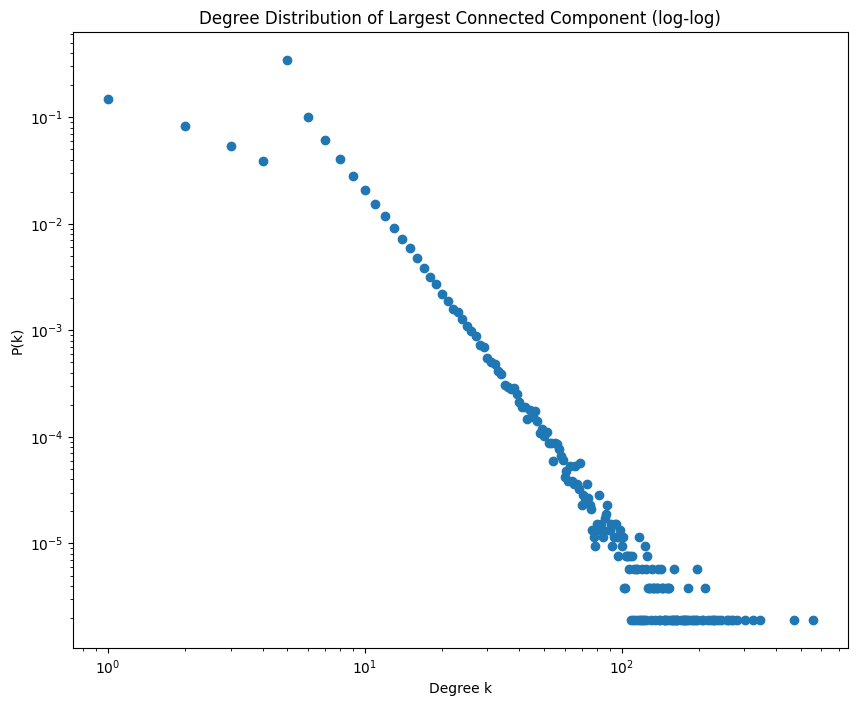

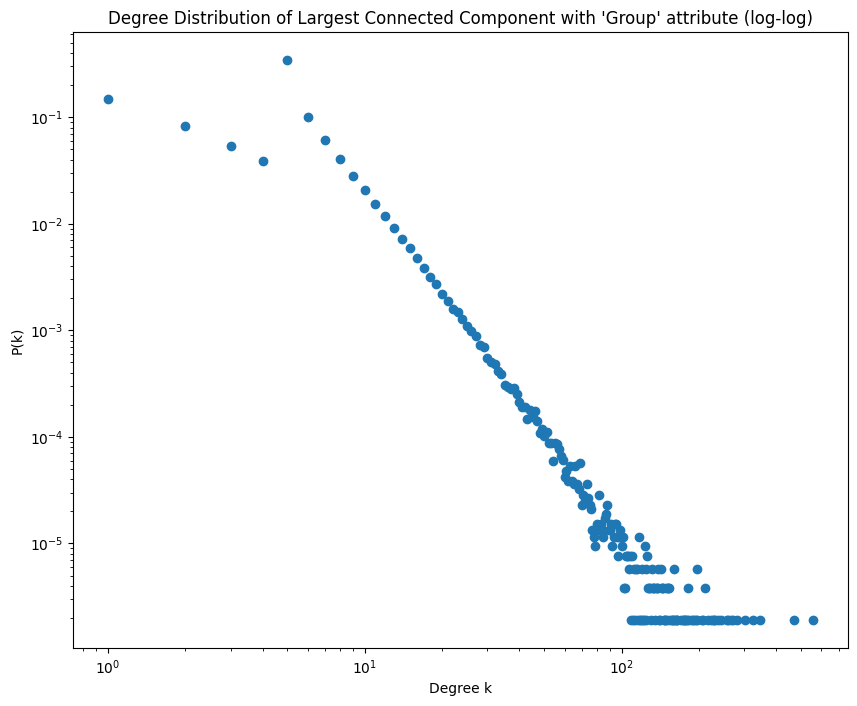

In [43]:
def Degree_Distribution_Histogram(G, Graph_used):
    # Sequence
    degs = [d for _, d in G.degree()]
    # Get count of each degree 
    deg_counts = np.bincount(degs)
    # get total sum of counts
    sum = deg_counts.sum()
    # Get indices that are non-zero
    idxs = np.nonzero(deg_counts)[0]
    # distribution calculation
    distribution = deg_counts[deg_counts > 0] / sum
    
    # Start Plot
    plt.figure(figsize=(10,8))
    plt.loglog(idxs, distribution, marker='o', linestyle='')
    plt.xlabel("Degree k")
    plt.ylabel("P(k)")
    plt.title(f"Degree Distribution of {Graph_used} (log-log)")
    plt.show()
    
Degree_Distribution_Histogram(G_largest, "Largest Connected Component")
Degree_Distribution_Histogram(G_largest, "Largest Connected Component with 'Group' attribute")

using https://lite.gephi.org/v1.0.2/ to visualize graph due to large size

In [4]:
# Export a to GEXF (To use with Gephi)
# def export_to_Gephi(G, name):
#     # Create Copy of G to avoid changing graph
#     G_copy = copy.deepcopy(G)
#     # Drop categories because it is not gexf safe type
#     for n, data in G_copy.nodes(data=True):
#         if 'categories' in data:
#             del data['categories']
#     nx.write_gexf(G_copy, name+".gexf")
    
# export_to_Gephi(G_group_largest, "amazon_largest_group_largest")




## Centralities
Assigned: Isabell

Questions Proposed:
1. Which products have central positions within co-purchased products?
    - Is there a correlation/connection among central products’ attributes
2. Use and compare different centralities to determine general specifics about the graph

Types of centralities:
- degree
    - counts ***products directly co-purchased together***
    - high value means "bought together with many other distinct products"
    - identify ***hubs*** 
- betweenness
    - how ***often*** a product lies on the ***"shortest path"*** of other products 
    - high value means "may act as a 'bridge' between clusters of products"
    - identify ***bridges***
- eigenvector
    - how many and how ***important are the neighbors***
    - high value if purchased with other "important" products
    - identify ***core/anchor*** products
- closeness 
    - how ***close a product is to other products***
    - high value means product is "on average" a few co-purchase links away from all other products
    

Ideas:
- Cluster by centrality groups and see if there is a correlation for any of them

### Compute Centralities

In [5]:
# Degree
cen_lgroup_deg = nx.degree_centrality(G_group_largest)
print("Done deg")


"""
    Exchange networkX methods for a faster method -> NetworKit
    
    NetworKit 
        - python package compiled with C++ core
        
    returns list of closeness, eigenvector, betweeness of nx_graph nodes
"""
def centralities_networkit(G):
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    # Create maps so that we can flip between nx and nk graphs while keeping track of which node is which
    map_node_id = {u: i for i, u in enumerate(nodes)}
    map_node_label = {i: u for u, i in map_node_id.items()}
    
    # Build nk graph
    G_nk = nk.Graph(num_nodes, directed = False)
    for u, v in G.edges():
        G_nk.addEdge(map_node_id[u], map_node_id[v])
    # Set number of threads to use
    nk.setNumberOfThreads(nk.getMaxNumberOfThreads())
    print(f"NerworKit using {nk.getCurrentNumberOfThreads()} threads")
    
    """ Closeness
    
    Tuning Variables:
        nSamples 
            100-300 range
            Success with 200(16 sec), 300(16 sec), 400(16 sec)
        epsilon -> when to sample when to pivot
            Success with 0.1 for all nSamples, 0.05(nSamples=400 at 30 sec)
    """
    clo_nk = nk.centrality.ApproxCloseness(
        G_nk,
        nSamples= 400,
        epsilon= 0.05,
        normalized=True,
        type=nk.centrality.ClosenessType.OUTBOUND
    )
    clo_nk.run()
    clo_nk_scores = clo_nk.scores()
    print("Done clo")
    
    """ Eigenvector
    
    Tuning Variables:
        tol 
            increase -> laster -> less accurate
            decrease > more iterations -> closer to true
            Success with 1e-4, 1e-8, 1e-9 (10 sec)
    """
    eig_nk = nk.centrality.EigenvectorCentrality(G_nk, tol=1e-9)
    eig_nk.run()
    eig_nk_scores = eig_nk.scores()
    print("Done eig")
    
    """ ApproxBetweennness
    
    Tuning Variables:
        epsilon 
            increase for faster results
            decrease for more accurate results
            Success with 0.03(minutes), 0.01 (30 minutes)
        delta - probability of being within epsilon
            default is 0.1
            Success with 0.1 for all epsilon. 0.05(epsilon=0.03 4 minutes)
    """
    bet_nk = nk.centrality.ApproxBetweenness(
        G_nk,
        epsilon = 0.01,
        delta = 0.05
    )
    bet_nk.run()
    bet_nk_scores = bet_nk.scores()
    print("Done approx bet")
    
    
    # Revert back to nx graph nodes
    clo_nx = dict(zip(nodes, clo_nk_scores))
    eig_nx = dict(zip(nodes, eig_nk_scores))
    bet_nx = dict(zip(nodes, bet_nk_scores))
    
    # Revert back to nx graph nodes
    return clo_nx, eig_nx, bet_nx
    
cen_lgroup_clo, cen_lgroup_eig, cen_lgroup_bet = centralities_networkit(G_group_largest)

Done deg
NerworKit using 1 threads
Done clo
Done eig
Done approx bet


### Compare Top 10 Centralities

In [8]:
# Sort each centrality
cen_lgroup_deg_sort = sorted(cen_lgroup_deg.items(), key=lambda x: x[1], reverse=True)
cen_lgroup_clo_sort = sorted(cen_lgroup_clo.items(), key=lambda x: x[1], reverse=True)
cen_lgroup_eig_sort = sorted(cen_lgroup_eig.items(), key=lambda x: x[1], reverse=True)
cen_lgroup_bet_sort = sorted(cen_lgroup_bet.items(), key=lambda x: x[1], reverse=True)
# Sort and grab top 10 of each centrality
cen_lgroup_deg_top10 = cen_lgroup_deg_sort[:10]
cen_lgroup_clo_top10 = cen_lgroup_clo_sort[:10]
cen_lgroup_eig_top10 = cen_lgroup_eig_sort[:10]
cen_lgroup_bet_top10 = cen_lgroup_bet_sort[:10]        

In [39]:
# Print formater
#             rank     rank2    rank3    rank4    ASIN     Group  Salesrank avg_rating
formatter = "{:<25} | {:<25} | {:<25} | {:<25} | {:<15} | {:<15} | {:<15} | {:<10} |"
FORMAT_YELLOW = "\033[1;33m"
FORMAT_BLUE= "\033[1;34m"
FORMAT_GREEN = "\033[1;32m"
RESET_FORMAT = "\033[0m"

cen_types = ["Degree Rank", "Closeness", "Eigenvector", "Betweenness"]
loop_values = {cen_types[0]: cen_lgroup_deg_top10, cen_types[1]: cen_lgroup_clo_top10, cen_types[2]: cen_lgroup_eig_top10, cen_types[3]: cen_lgroup_bet_top10}
cent_dict = {cen_types[0]: cen_lgroup_deg_sort, cen_types[1]: cen_lgroup_clo_sort, cen_types[2]: cen_lgroup_eig_sort, cen_types[3]: cen_lgroup_bet_sort}
# For each Top 10 of each Centrality
for cen_name, values in loop_values.items():
    other_cen = copy.deepcopy(cen_types)
    other_cen.remove(cen_name)
    # Print Rank     Rank in other centralities     ASIN       Group    Salesrank   avg_rating
    print(formatter.format(cen_name + " Rank (Value)", other_cen[0] + " Rank (Value)", other_cen[1] + " Rank (Value)", other_cen[2] + " Rank (Value)", "Node_Id(ASIN)", "Group", "Salesrank", "Avg_Rating"))
    
    # For each value print the node's information
    for r1, (node, value) in enumerate(values):
        # Find rank and value for each other centrality
        r2 = next(((i, t[1]) for i, t in enumerate(cent_dict[other_cen[0]]) if t[0] == node), None)
        r3 = next(((i, t[1]) for i, t in enumerate(cent_dict[other_cen[1]]) if t[0] == node), None)
        r4 = next(((i, t[1]) for i, t in enumerate(cent_dict[other_cen[2]]) if t[0] == node), None)
        
        change_format = None        
        # If other centrality rankings are <=10 change text color
        nums = [r2[0], r3[0], r4[0]]
        count = sum(1 for n in nums if n < 10)
        if count > 0:
            change_format = FORMAT_YELLOW if count == 1 else (FORMAT_BLUE if count == 2 else FORMAT_GREEN)
            
        # Print table row
        print(formatter.format(
            change_format + f"{f"{r1:<10}({value:0.4f})":<25}" + RESET_FORMAT if count > 0 else f"{r1:<10}({value:0.4f})",
            change_format + f"{f"{r2[0]:<10}({r2[1]:0.4f})":<25}" + RESET_FORMAT if nums[0] < 10 else f"{r2[0]:<10}({r2[1]:0.4f})",
            change_format + f"{f"{r3[0]:<10}({r3[1]:0.4f})":<25}" + RESET_FORMAT if nums[1] < 10 else f"{r3[0]:<10}({r3[1]:0.4f})",
            change_format + f"{f"{r4[0]:<10}({r4[1]:0.4f})":<25}" + RESET_FORMAT if nums[2] < 10 else f"{r4[0]:<10}({r4[1]:0.4f})",
            change_format + f"{f"{node}":<15}" + RESET_FORMAT if count > 0 else f"{node}",
            change_format + f"{f"{G.nodes[node]["group"]}":<15}" + RESET_FORMAT if count > 0 else f"{G.nodes[node]["group"]}",
            change_format + f"{f"{G.nodes[node]["salesrank"]}":<15}" + RESET_FORMAT if count > 0 else f"{G.nodes[node]["salesrank"]}",
            change_format + f"{f"{G.nodes[node]["avg_rating"]}":<10}" + RESET_FORMAT if count > 0 else f"{G.nodes[node]["avg_rating"]}",
        ))
    print()

Degree Rank Rank (Value)  | Closeness Rank (Value)    | Eigenvector Rank (Value)  | Betweenness Rank (Value)  | Node_Id(ASIN)   | Group           | Salesrank       | Avg_Rating |
0         (0.0016)        | 529       (0.1129)        | 321       (0.0048)        | 7         (0.0193)        | B00008LDNZ      | DVD             | 110             | 5.0        |
1         (0.0010)        | 23        (0.1192)        | 11200     (0.0000)        | 10        (0.0127)        | 0890420254      | Book            | 371             | 4.0        |
2         (0.0008)        | 7         (0.1222)        | 6071      (0.0000)        | 2         (0.0246)        | 1557987912      | Book            | 143             | 3.5        |
3         (0.0007)        | 1         (0.1239)        | 305       (0.0087)        | 16        (0.0106)        | 0684801523      | Book            | 956             | 4.0        |
4         (0.0007)        | 1268      (0.1106)        | 2832      (0.0001)        | 64        (0.0041)   

Lines are highlighted that encase nodes that are in the top 10 list from
    - Yellow : 2 different centralities
    - Blue : 3 different centralities
    - Green : 4 different centralities

### Plot Centralities

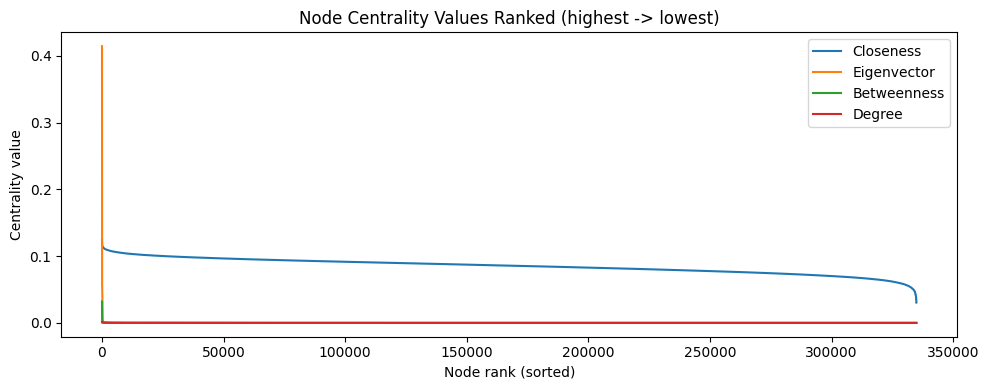

In [ ]:
# Sort centrality values in descending order
plt_deg_vals = np.sort(list(cen_lgroup_deg.values()))[::-1]
plt_clo_vals = np.sort(list(cen_lgroup_clo.values()))[::-1]
plt_eig_vals = np.sort(list(cen_lgroup_eig.values()))[::-1]
plt_bet_vals = np.sort(list(cen_lgroup_bet.values()))[::-1]
# Plot centrality values for each node
plt.figure(figsize=(10, 4))
plt.plot(plt_clo_vals, label="Closeness")
plt.plot(plt_eig_vals, label="Eigenvector")
plt.plot(plt_bet_vals, label="Betweenness")
plt.plot(plt_deg_vals, label="Degree")
plt.xlabel("Node rank (sorted)")
plt.ylabel("Centrality value")
plt.title("Node Centrality Values Ranked (highest -> lowest)")
plt.legend()
plt.tight_layout()
plt.show()

## Community Detection
Assigned: 

3.6


## Link Prediction
Assigned: 